# eforecast runner

 - This notebook provides an example run script of the eforecaster module.
 - Each stage of building the forecast and testing the predictions is demonstrated with an example data set.
 - Visualisations are also provided at each stage.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from forecasters import feature_factory as ff
from forecasters import boosted_hybrid as bh
from sklearn.metrics import mean_absolute_error

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Run these if making changes to the underlying codebase to avoid having to restart notebook
# import importlib
# importlib.reload(ff)
# importlib.reload(bh)

## Get the energy and weather data

In [3]:
df_energy = pd.read_csv("test_data/df_daily_test_data.csv", parse_dates=["ts"], 
                       index_col=["ts"]).rename(columns={"energy_kWh": "y"})

In [4]:
# Get weather data
df_weather = pd.read_csv("test_data/london_weather.csv", usecols=["tempmax", "tempmin", "temp",
                                                              "feelslike", "sunrise", "sunset",
                                                              "datetime"],
                         parse_dates=["datetime"], index_col=["datetime"])

In [5]:
# Combine weather data with target data
df_input = pd.concat([df_energy, df_weather], axis=1, ignore_index=False)

## Instantiate the feature factory and make some features

In [6]:
factory = ff.FeatureFactory(df_input)

In [7]:
X_trend = factory.create_time_trend_features(order=1)

Creating time trend features of order: 1


In [8]:
X_lag = factory.create_lag_features(lag_steps=7)

Creating lag features of lag: 7


In [9]:
X_seasonal = factory.create_fourier_features(freq="y", fourier_order=12)

Creating seasonal features for Fourier freq: y and Fourier order: 12


In [10]:
X_statistical = factory.create_statistical_features(mean_window=7, median_window=7, stdev_window=7)

Creating rolling window statistical features of mean_7, median_7, stdev7


In [11]:
X_temperature = factory.create_temperature_features(["temp", "feelslike"])

Creating temperature feature for ['temp', 'feelslike']


In [12]:
X_daylength = factory.create_daylength_features("sunrise", "sunset")

Creating daylength feature using cols: ('sunrise', 'sunset')


In [30]:
# Include y here to so we can easily drop nans across features and target data
X_features = factory.combine_features([X_trend, X_lag, X_statistical, X_seasonal, X_temperature,
                                      X_daylength, df_energy.y])


In [31]:
X_features.columns

Index(['const', 'trend', 'mean_7', 'median_7', 'stdev_7', 'const', 's(2,7)',
       's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)', 's(7,7)', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)',
       'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)', 'cos(5,freq=A-DEC)',
       'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)', 'sin(7,freq=A-DEC)',
       'cos(7,freq=A-DEC)', 'sin(8,freq=A-DEC)', 'cos(8,freq=A-DEC)',
       'sin(9,freq=A-DEC)', 'cos(9,freq=A-DEC)', 'sin(10,freq=A-DEC)',
       'cos(10,freq=A-DEC)', 'sin(11,freq=A-DEC)', 'cos(11,freq=A-DEC)',
       'sin(12,freq=A-DEC)', 'cos(12,freq=A-DEC)', 'temp', 'feelslike',
       'daylength', 'y'],
      dtype='object')

## Linear regression visualisaiton
 - Apply simple lin regression to features and plot original data and model fit
 - Note, here we are just plotting self predictions not future forecast

In [32]:
# Drop NaNs and set up the X and y dfs

X_reg = X_features.copy()
X_reg = X_reg.dropna(axis=0)

y_reg = X_reg.y
X_reg = X_reg.drop(columns=["y"])

In [33]:
# Train model
model_reg = LinearRegression()
model_reg.fit(X_reg, y_reg)

# Store fitted values a new time series
y_reg_pred = pd.Series(model_reg.predict(X_reg), index=X_reg.index)

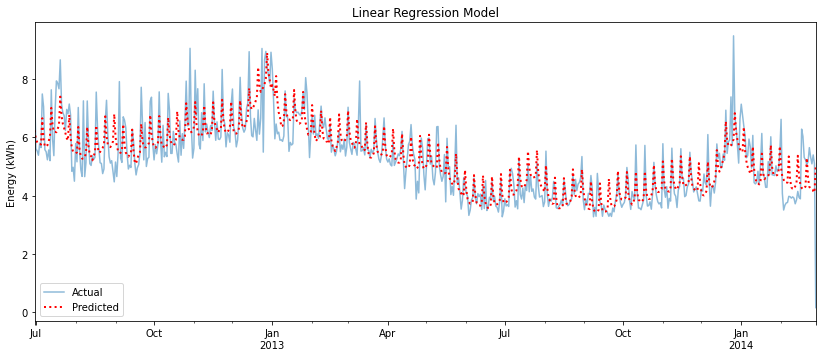

score: 0.731004010720248


In [34]:
# Plot target and predicted target

ax = y_reg.plot(alpha=0.5, figsize=(14, 5.5), label="Actual")
ax = y_reg_pred.plot(ax=ax, linewidth=2, label="Predicted", color="r", linestyle=":")
ax.set_title("Linear Regression Model")
ax.set_ylabel("Energy (kWh)")
plt.legend()
plt.show()

print(f"score: {model_reg.score(X_reg, y_reg)}")

## Boosted Hybrid Visualisation

 - Combined lin reg, then boosted hybrid fit to the residuals

In [35]:
# Re-use the same features we created above for the linear regression

# Create a new feature df for the XG boost

# Features for XGBoost
X_xgb = factory.combine_features([X_lag, X_statistical, X_temperature, X_daylength, df_energy.y])

X_xgb = X_xgb.dropna(axis=0)

# Label encoding for day of week
X_xgb["day"] = X_xgb.index.day_of_week

y_xgb = X_xgb.y
X_xgb = X_xgb.drop(columns=["y"])

In [36]:
# Initialise boost class 
importlib.reload(bh)
model_xgb = bh.BoostedHybrid(model_1=LinearRegression(), model_2=XGBRegressor())

In [37]:
# Fit the model and get self-predictions
model_xgb.fit(X_reg, X_xgb, y_xgb)

y_xgb_pred = model_xgb.predict(X_reg, X_xgb)
#y_xgb_pred = y_xgb_pred.clip(0.0)

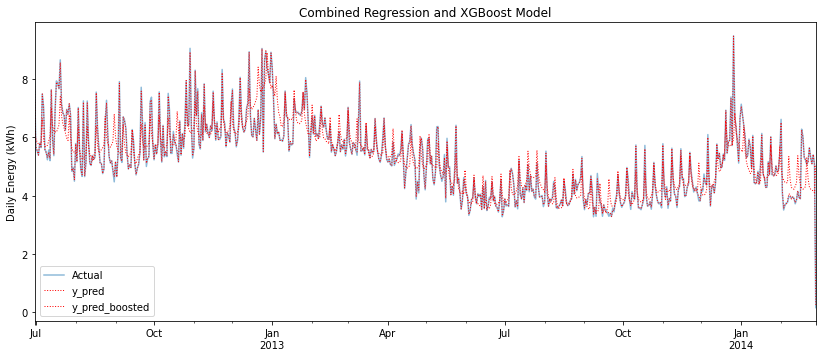

In [38]:
# Plot target and predicted target

ax2 = y_xgb.plot(alpha=0.5, figsize=(14, 5.5), label="Actual")
y_xgb_pred.plot(ax=ax2, linewidth=1, label="Predicted", color="r", linestyle=":")
ax2.set_title("Combined Regression and XGBoost Model")
ax2.set_ylabel("Daily Energy (kWh)")
plt.legend()
plt.show()

## Run a future forecast over multiple time windows

 - Create sliding window, consisting of a training period, immediately followed by the test period.
 - The window moves through the data set one step at a time to test the model across multiple train/test periods.
 - The training period (e.g. 1 year) is used to fit the model
 - The test period corresponds to a forecast period (e.g. 7 days ahead) where the model makes a prediction without having seen any data for that period.

In [39]:
from forecasters import validate_forecaster as vf
import importlib
importlib.reload(vf)

<module 'forecasters.validate_forecaster' from '/home/shem/repos/eforecast/forecasters/validate_forecaster.py'>

In [42]:
# Initialise the ValidateForecaster class with the feature sets for model_1 (lin reg) and model_2 (xgboost)

# Set kwarg tuning parameters here too if required

# Set naive forecast as just y with lag 7 (i.e the value one week previously)
naive_forecast = X_lag

xgb_tuning_params = {"n_estimators": 15, "colsample_bytree": 1, "eta": 0.1, "max_depth": 5,
                    "subsample": 1} 
validation = vf.ValidateForecaster(X_reg, X_xgb, y_xgb, naive_forecast, xgb_tuning_params)

### Run the validation, 

 - num_samples corresponds to number of steps the sliding window will move through
 - Metrics is a df of error metrics for model_1 (reg) and model_2 (xgb) for the train (self-predict) and test (forecast) periods.
 - Default error metric is MAE, others can be requested when calling run.

Running validation for 
train_len: 365 
test_len: 7 
num_samples: 200 
error_metric: mean_absolute_error


41it [00:15,  2.63it/s]

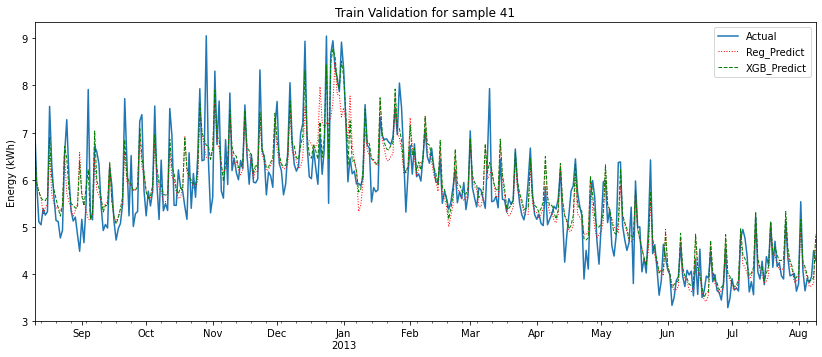

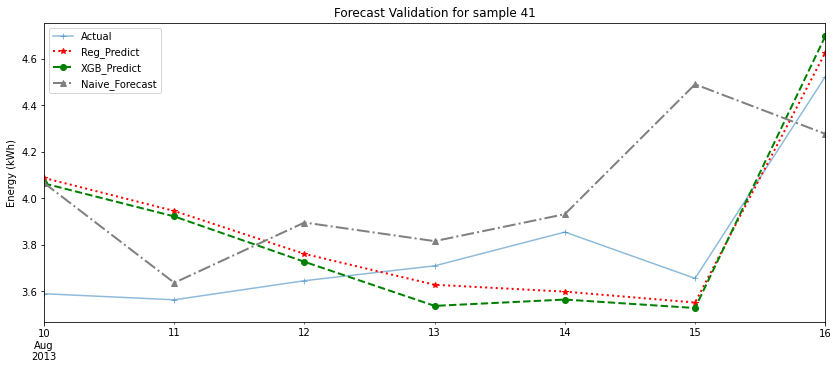

60it [00:23,  2.53it/s]

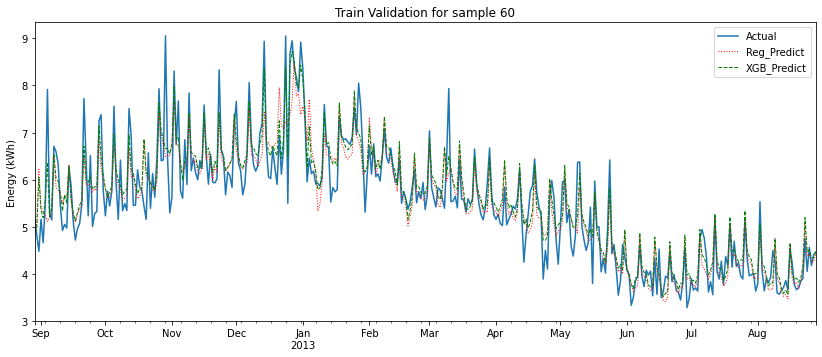

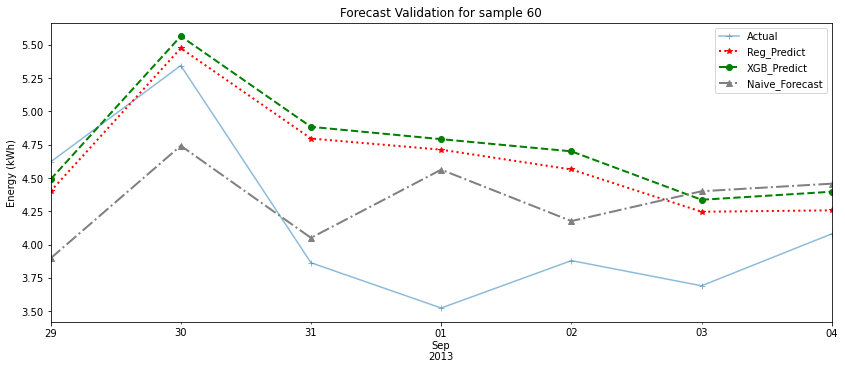

84it [00:33,  2.74it/s]

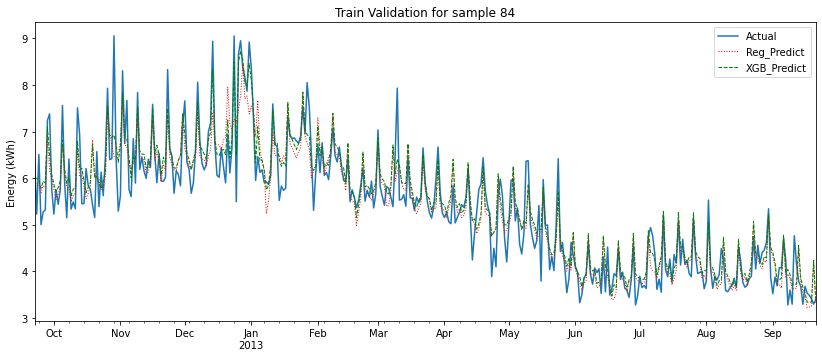

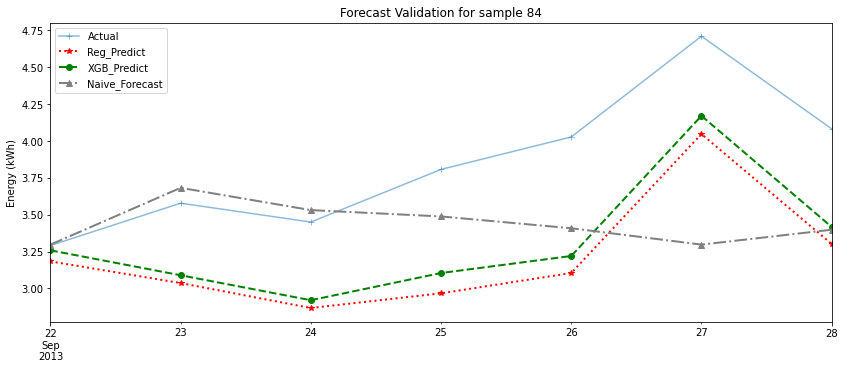

187it [01:11,  2.67it/s]

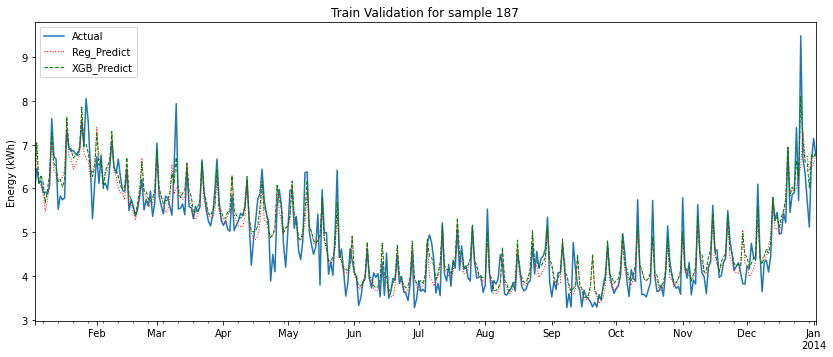

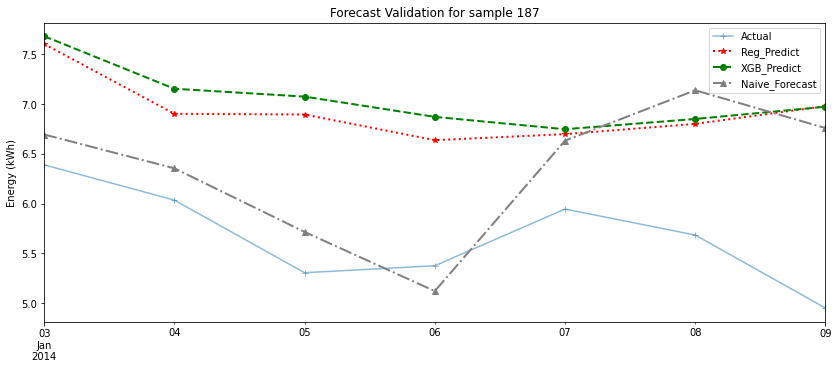

200it [01:17,  2.59it/s]


In [43]:
df_metrics = validation.run(num_samples=200, error_metric=metrics.mean_absolute_error, plotting=True)

In [25]:
df_metrics.mean()

/tmp/ipykernel_7699/1171370760.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_metrics.mean()


mean_absolute_error_train_xgb               0.328216
mean_absolute_error_train_reg               0.384918
mean_absolute_error_train_naive_forecast    0.581954
mean_absolute_error_test_xgb                0.496831
mean_absolute_error_test_reg                0.487583
mean_absolute_error_test_naive_forecast     0.470499
dtype: float64

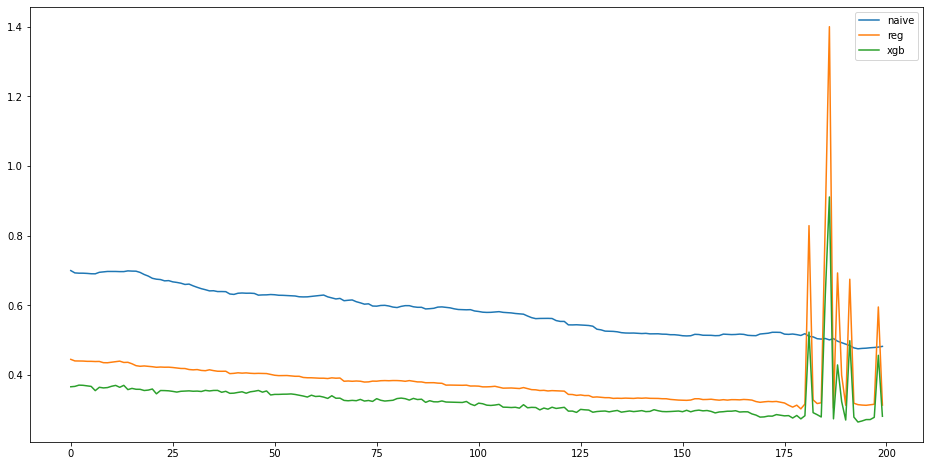

In [26]:
plt.figure(figsize=(16,8))
plt.plot(df_metrics.mean_absolute_error_train_naive_forecast, label="naive")
plt.plot(df_metrics.mean_absolute_error_train_reg, label="reg")
plt.plot(df_metrics.mean_absolute_error_train_xgb, label="xgb")
plt.legend()

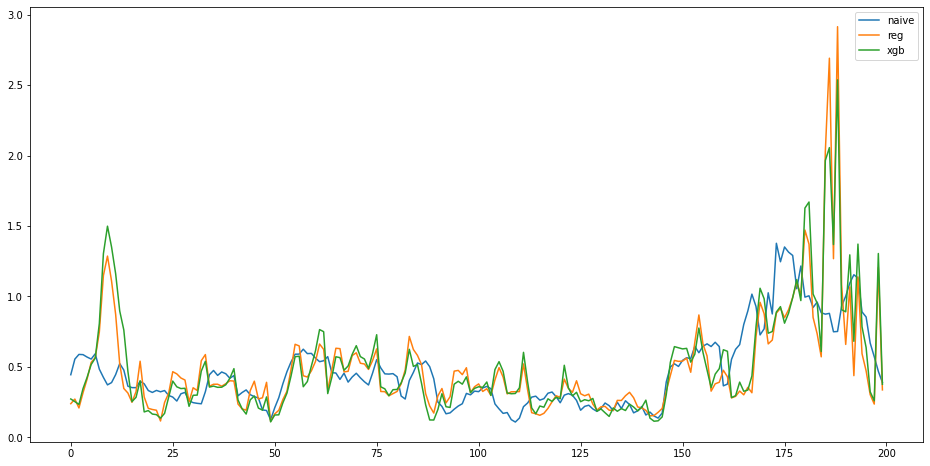

In [27]:
plt.figure(figsize=(16,8))
plt.plot(df_metrics.mean_absolute_error_test_naive_forecast, label="naive")
plt.plot(df_metrics.mean_absolute_error_test_reg, label="reg")
plt.plot(df_metrics.mean_absolute_error_test_xgb, label="xgb")
plt.legend()

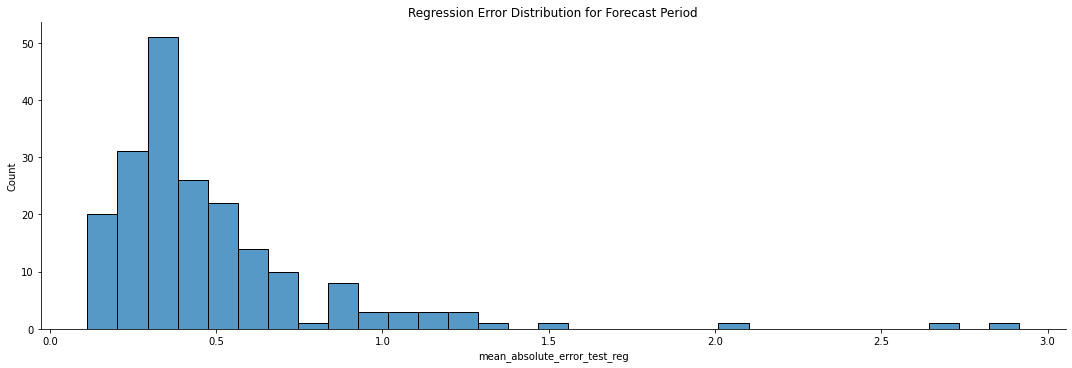

In [28]:
sns.displot(data=df_metrics.mean_absolute_error_test_reg, kde=False, aspect=24/8)
plt.title("Regression Error Distribution for Forecast Period")
plt.show()

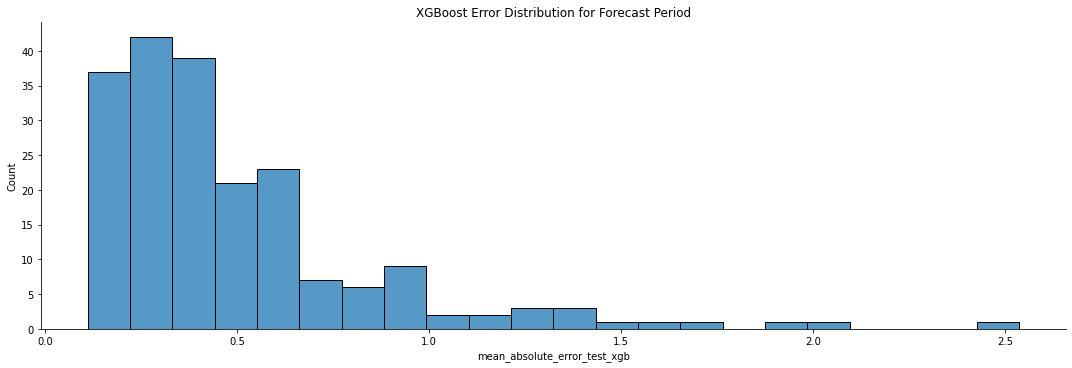

In [29]:
sns.displot(data=df_metrics.mean_absolute_error_test_xgb, kde=False, aspect=24/8)
plt.title("XGBoost Error Distribution for Forecast Period")
plt.show()

## TODO
 - Add some checks that requested samples and train/test length fit the data we pass in DONE
 - Plot 10 random samples from the validate method DONE
 - Add 3 tests just as a start/template
 - Tidy up notebook to show a simple implementation of LinReg, LinReg+Boost, Validation DONE
 - Plot error metrics distribution
 - Set some parameters on the boost to avoid overfitting see if it improves things DONE -added options
 - Documentation and clean up

## To do
 - add temp feature DONE
 - add holiday feature
 - add simple error metrics function for training and validation periods
 - add a sliding window approach for multiple validation period (or see if train-test split can be adapted)